# Classificador Valência em Tweets

In [174]:
# encoding: utf-8
# encoding: iso-8859-1
# encoding: win-1252

import pandas as pd
import csv
from datetime import datetime
from dateutil import parser
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix



### Dataset com Demojize
O Demojize faz uma conversão dos emojis para seu código, por exemplo 

In [67]:
### Com Demogize
datasetInFrame = pd.read_csv("demojized_emojios.csv", sep="|",quoting=csv.QUOTE_ALL)
### Colocando espaços entre os emojis
sentencesEmojis = [str(sentence).lower().replace(":"," ") for sentence in datasetInFrame["txt"]]
datasetInFrame["txt"] = sentencesEmojis

### Dataset com Emoji

In [68]:
### Com emoji
#datasetInFrame = pd.read_csv("output-pleasure-arousal-labeled-emoji.csv", sep="|",quoting=csv.QUOTE_ALL)

### Dataset sem Emoji

In [69]:
### Sem emoji
#datasetInFrame = pd.read_csv("output-pleasure-arousal-labeled.csv", sep="|", encoding="ISO-8859-1",quoting=csv.QUOTE_ALL)

In [72]:
datasetInFrame.describe()


,val,int,dia
count,1318.000000,1318.000000,1318.000000
mean,3.881639,3.761002,4.028073
std,1.380946,1.672438,1.692352
min,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000
50%,4.000000,4.000000,4.000000
75%,5.000000,5.000000,5.000000
max,7.000000,7.000000,7.000000


## Verificando a distribuição das Classes:
Intensidade: 1 a 7
Valência: 1 a 7

In [73]:
totalIntensityClasses = {}

for i in range(1,8):
    totalIntensityClasses[i] = datasetInFrame[datasetInFrame.int == i]["txt"].count()
totalIntensityClasses

{1: 129, 2: 218, 3: 243, 4: 273, 5: 229, 6: 156, 7: 70}

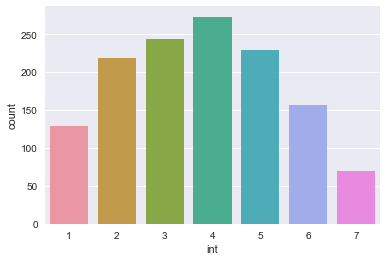

In [74]:
sns.countplot(x='int', data=datasetInFrame)

In [75]:
totalValencyClasses = {}

for i in range(1,8):
    totalValencyClasses[i] = datasetInFrame[datasetInFrame.val == i]["txt"].count()
totalValencyClasses

{1: 49, 2: 189, 3: 316, 4: 225, 5: 413, 6: 106, 7: 20}

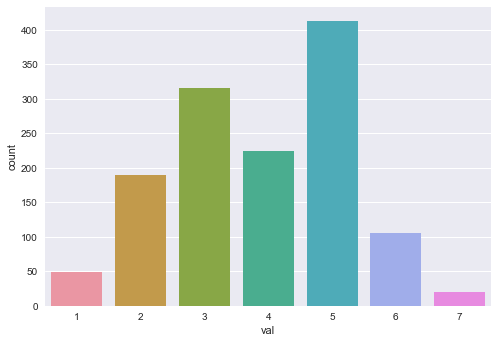

In [8]:
sns.countplot(x='val', data=datasetInFrame)

## Separando data e hora

In [77]:
dateTime = datasetInFrame["data"].apply(lambda  x: x.split(' '))
date = dateTime.apply(lambda x: x[0])
time = dateTime.apply(lambda x: x[1])
datasetInFrame["date"] = date
datasetInFrame["time"] = time
del datasetInFrame["data"]
datasetInFrame.head()


KeyError: 'data'

## Substituindo Valores Para Cidade
1. Removendo o País;
2. Substituindo: 
    * Rio de Janeiro = 1 
    * São Paulo = 2

In [78]:
city = datasetInFrame["cit"].apply(lambda x: x.split(','))
datasetInFrame["cit"] = city.apply(lambda x: x[0])
datasetInFrame.head()

,id,txt,val,int,cit,dia,date,time
0,line_fdl,"tô tão pensativa ultimamente, nn tô me sentind...",3,3,Rio de Janeiro,6,10/27/2017,0:17:49
1,line_fdl,guilherme só aparece aqui em casa p fazer barb...,5,4,Rio de Janeiro,5,10/26/2017,20:47:35
2,line_fdl,amo cheiro de café pela manhã.. hot_beverage ...,5,4,Rio de Janeiro,5,10/26/2017,9:45:33
3,line_fdl,tô meio aérea,4,2,Rio de Janeiro,5,10/26/2017,1:24:55
4,line_fdl,"tô mega cansada nn sei que cançaso é esse, só ...",2,4,Rio de Janeiro,5,10/26/2017,0:56:21


In [79]:
#datasetInFrame["cit"] = datasetInFrame["cit"].apply(lambda x: 1 if x == "Rio de Janeiro" else 2)
#datasetInFrame

## Criando *features*
1. isWeekend? [dia 6 após às 19:00, dia 7  e  1 até 19:00 sim 0 não
2. isMad? 1 sim 0 não

In [80]:
def isWeekend(day,hour):
    format = '%H:%M:%S'
    hour = datetime.strptime(hour, format)
    limitWeekend = datetime.strptime("19:00:00", format)
    if (day == 6) and (hour >= limitWeekend):
        return 1
    elif (day == 1) and (hour < limitWeekend):
        return 1
    elif day == 7:
        return 1
    else:
        return 0

datasetInFrame['isWeekend'] = pd.Series(np.zeros(len(datasetInFrame)), index=datasetInFrame.index)

for index, row in datasetInFrame.iterrows():
    datasetInFrame.loc[index,"isWeekend"] = isWeekend(row["dia"],row["time"])
datasetInFrame.head()

,id,txt,val,int,cit,dia,date,time,isWeekend
0,line_fdl,"tô tão pensativa ultimamente, nn tô me sentind...",3,3,Rio de Janeiro,6,10/27/2017,0:17:49,0.0
1,line_fdl,guilherme só aparece aqui em casa p fazer barb...,5,4,Rio de Janeiro,5,10/26/2017,20:47:35,0.0
2,line_fdl,amo cheiro de café pela manhã.. hot_beverage ...,5,4,Rio de Janeiro,5,10/26/2017,9:45:33,0.0
3,line_fdl,tô meio aérea,4,2,Rio de Janeiro,5,10/26/2017,1:24:55,0.0
4,line_fdl,"tô mega cansada nn sei que cançaso é esse, só ...",2,4,Rio de Janeiro,5,10/26/2017,0:56:21,0.0


In [81]:
def isMad(hour):
    format = '%H:%M:%S'
    hour = datetime.strptime(hour, format)
    initLimit = datetime.strptime("23:00:00", format)
    endLimit = datetime.strptime("05:00:00", format)
    
    if (hour >= initLimit) or (hour < endLimit):
        return 1
    else:
        return 0

    
datasetInFrame['isMad'] = pd.Series(np.zeros(len(datasetInFrame)), index=datasetInFrame.index)

for index, row in datasetInFrame.iterrows():
    datasetInFrame.loc[index,"isMad"] = isMad(row["time"])
datasetInFrame.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
0,line_fdl,"tô tão pensativa ultimamente, nn tô me sentind...",3,3,Rio de Janeiro,6,10/27/2017,0:17:49,0.0,1.0
1,line_fdl,guilherme só aparece aqui em casa p fazer barb...,5,4,Rio de Janeiro,5,10/26/2017,20:47:35,0.0,0.0
2,line_fdl,amo cheiro de café pela manhã.. hot_beverage ...,5,4,Rio de Janeiro,5,10/26/2017,9:45:33,0.0,0.0
3,line_fdl,tô meio aérea,4,2,Rio de Janeiro,5,10/26/2017,1:24:55,0.0,1.0
4,line_fdl,"tô mega cansada nn sei que cançaso é esse, só ...",2,4,Rio de Janeiro,5,10/26/2017,0:56:21,0.0,1.0


## Histogramas do Dataset

### Valência entre Final de Semana (1.0) e Dia de Semana (0.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000042B2B40C50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000042B2B5F1D0>], dtype=object)

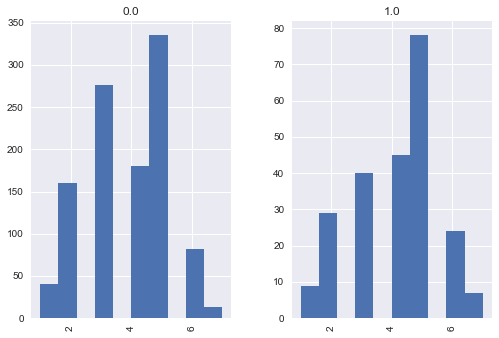

In [15]:
#Valência em Fim de Semana
datasetInFrame.hist(column='val',by='isWeekend', bins=10)

### Valência na Madrugada (1.0) e Não (0.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000042B2C892B0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000042B22A5550>], dtype=object)

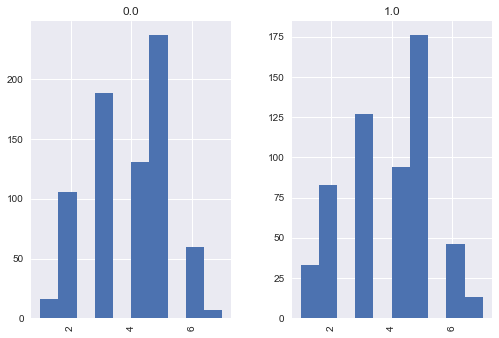

In [16]:
#Valência na Madrugada
datasetInFrame.hist(column='val',by='isMad', bins=10)

### Valência por Cidade

In [ ]:
#Valência por Cidade
datasetInFrame.hist(column='val',by='cit', bins=10)

### Valência por Intensidade

In [ ]:
#Valência por Intensidade
datasetInFrame.hist(column='val',by='int', bins=10)

### Valência por Dia

In [ ]:
datasetInFrame.hist(column='val',by='date', bins=10)

## Removendo colunas

Colunas removidas: date, time, cit e int

In [ ]:
### Usuários
users = []
for i in datasetInFrame['id'].unique():
    users.append(i)

## Balanceando os dados

In [82]:
balancedDataset = pd.DataFrame()
limitSamples = 100
for i in datasetInFrame['val'].unique():
    balancedDataset = balancedDataset.append(datasetInFrame[datasetInFrame['val'] == i].iloc[:limitSamples],ignore_index=True)
    
balancedDataset.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
0,line_fdl,"tô tão pensativa ultimamente, nn tô me sentind...",3,3,Rio de Janeiro,6,10/27/2017,0:17:49,0.0,1.0
1,line_fdl,joana fez eu me arrumar atoa affff cr,3,5,Rio de Janeiro,4,10/25/2017,0:45:39,0.0,1.0
2,line_fdl,tô tão sem paciência sem.or,3,5,Rio de Janeiro,6,10/20/2017,23:25:23,1.0,1.0
3,line_fdl,até gosto de calor mas tá de mais mds scrr,3,4,Rio de Janeiro,5,10/19/2017,22:36:52,0.0,0.0
4,line_fdl,tô com uma dorzinha d cabeça q ta me dx enjoad...,3,4,Rio de Janeiro,4,10/18/2017,22:33:22,0.0,0.0


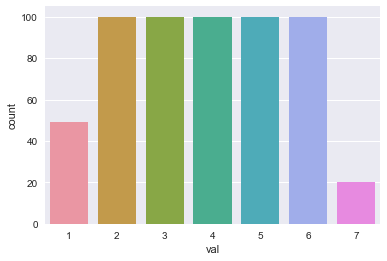

In [83]:
sns.countplot(x='val', data=balancedDataset)

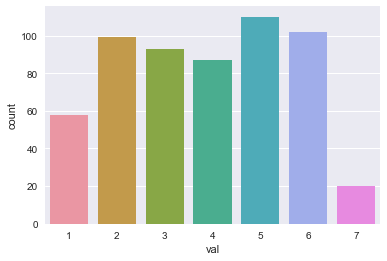

In [84]:
#Seleciona aleatóriamente
dataset = balancedDataset.sample(len(balancedDataset), replace=True)
sns.countplot(x='val', data=dataset)

In [86]:
dataset.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
198,sabrina_bazeth,"nao ame, faça amor victory_hand",5,3,Rio de Janeiro,2,10/23/2017,17:04:25,0.0,0.0
140,FabricioGemada,to badalado pela gaiola clinking_beer_mugs,5,4,Rio de Janeiro,1,10/22/2017,7:51:01,1.0,0.0
104,line_fdl,minhas conversas com anderson é só textão mise...,5,3,Rio de Janeiro,2,10/23/2017,14:47:18,0.0,0.0
353,dhiulia_robert,"o melhor é não fazer planos, porque a vida sem...",2,4,Rio de Janeiro,5,10/26/2017,23:20:50,0.0,1.0
462,BorjaFrancisco_,demarre carroll-d'lo-jarrett allen é o melhor...,6,5,Rio de Janeiro,1,10/22/2017,21:21:26,0.0,0.0


## Separando o Dataset

In [87]:
for i in dataset['val'].unique():
    x= datasetInFrame[datasetInFrame['val'] == i]
    print(len(x))

413
189
106
316
225
49
20


## Adicionando *features* de texto
1. Bag of words

## Removendo caracteres especiais

In [88]:
sentences = [str(sentence).lower().replace("'","").replace(".","").replace(",","").replace('"',"").replace("?","") for sentence in dataset["txt"]]
dataset["txt"] = sentences
dataset.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
198,sabrina_bazeth,nao ame faça amor victory_hand,5,3,Rio de Janeiro,2,10/23/2017,17:04:25,0.0,0.0
140,FabricioGemada,to badalado pela gaiola clinking_beer_mugs,5,4,Rio de Janeiro,1,10/22/2017,7:51:01,1.0,0.0
104,line_fdl,minhas conversas com anderson é só textão mise...,5,3,Rio de Janeiro,2,10/23/2017,14:47:18,0.0,0.0
353,dhiulia_robert,o melhor é não fazer planos porque a vida semp...,2,4,Rio de Janeiro,5,10/26/2017,23:20:50,0.0,1.0
462,BorjaFrancisco_,demarre carroll-dlo-jarrett allen é o melhor ...,6,5,Rio de Janeiro,1,10/22/2017,21:21:26,0.0,0.0


## Tokenizing

In [89]:
sentencesWithTokens = [nltk.word_tokenize(sentence.lower()) for sentence in dataset["txt"]]
dataset["txt"] = sentencesWithTokens
dataset.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
198,sabrina_bazeth,"[nao, ame, faça, amor, victory_hand]",5,3,Rio de Janeiro,2,10/23/2017,17:04:25,0.0,0.0
140,FabricioGemada,"[to, badalado, pela, gaiola, clinking_beer_mugs]",5,4,Rio de Janeiro,1,10/22/2017,7:51:01,1.0,0.0
104,line_fdl,"[minhas, conversas, com, anderson, é, só, text...",5,3,Rio de Janeiro,2,10/23/2017,14:47:18,0.0,0.0
353,dhiulia_robert,"[o, melhor, é, não, fazer, planos, porque, a, ...",2,4,Rio de Janeiro,5,10/26/2017,23:20:50,0.0,1.0
462,BorjaFrancisco_,"[demarre, carroll-dlo-jarrett, allen, é, o, me...",6,5,Rio de Janeiro,1,10/22/2017,21:21:26,0.0,0.0


## Removendo StopWords
E Removendo espaços

In [90]:
stops = set(stopwords.words("portuguese"))
#words = ' '.join([w for w in words if not w in stops])

sentencesWithoutStopWords = []
for i,row in dataset.iterrows():
    sentence =  ' '.join([w for w in row["txt"] if not w in stops])
#    for word in row["txt"]:
#        if not word in stop_words:
#            sentence = sentence + " "+ str(word)
    sentencesWithoutStopWords.append(sentence.strip())
dataset["txt"]=sentencesWithoutStopWords
dataset.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
198,sabrina_bazeth,nao ame faça amor victory_hand,5,3,Rio de Janeiro,2,10/23/2017,17:04:25,0.0,0.0
140,FabricioGemada,to badalado gaiola clinking_beer_mugs,5,4,Rio de Janeiro,1,10/22/2017,7:51:01,1.0,0.0
104,line_fdl,conversas anderson é textão misericórdia nn se...,5,3,Rio de Janeiro,2,10/23/2017,14:47:18,0.0,0.0
353,dhiulia_robert,melhor é fazer planos porque vida sempre dá je...,2,4,Rio de Janeiro,5,10/26/2017,23:20:50,0.0,1.0
462,BorjaFrancisco_,demarre carroll-dlo-jarrett allen é melhor tim...,6,5,Rio de Janeiro,1,10/22/2017,21:21:26,0.0,0.0


## Bag of Words

In [92]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z]\w+\b",lowercase=True, ngram_range=(1, 2))


datasetTrain = count_vect.fit_transform(dataset["txt"])

from pprint import pprint
pprint(count_vect.vocabulary_)

{'aaaaa': 0,
 'aaaaa geral': 1,
 'aaaaaaaaa': 2,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 3,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaa grinning_face': 4,
 'aaaahh': 5,
 'aaaahh heart_suit': 6,
 'aaaahh loudly_crying_face': 7,
 'abada': 8,
 'abada senna': 9,
 'abençoe': 10,
 'abençoe hoje': 11,
 'abraço': 12,
 'abri': 13,
 'abri porta': 14,
 'acaba': 15,
 'acaba hoje': 16,
 'acaba novela': 17,
 'acabei': 18,
 'acabei almoçar': 19,
 'acabei amassar': 20,
 'acabei assistir': 21,
 'acabouuuuu': 22,
 'acabouuuuu broken_heart': 23,
 'acha': 24,
 'acha tô': 25,
 'acham': 26,
 'acham boba': 27,
 'acho': 28,
 'acho ano': 29,
 'acho ja': 30,
 'acho vou': 31,
 'acompanhe': 32,
 'acompanhe broken_heart': 33,
 'acontecendo': 34,
 'acontecendo vida': 35,
 'acontecer': 36,
 'acorda': 37,
 'acorda td': 38,
 'acordado': 39,
 'acordado bunda': 40,
 'acordar': 41,
 'acordar cedo': 42,
 'acordar estressando': 43,
 'acorde': 44,
 'acordei': 45,
 'acordei cedo': 46,
 'acordei mal': 47,
 'acordo': 48,
 'acordo todos': 49,
 '

In [93]:
#datasetTrain.todense()
datasetTrain.shape

(569, 2823)

### Term Frequency-Inverse Document Frequency

In [94]:
from sklearn.feature_extraction.text import TfidfTransformer

# Comment lines below if you don't want to consider idf transformer
tfidf_transformer = TfidfTransformer(norm="l2",use_idf=True)
X_tfidf = tfidf_transformer.fit_transform(datasetTrain)

## Separando o dataset
70% e 30%

In [95]:
train = datasetTrain[:int(datasetTrain.shape[0] * 0.7)]
trainTarget = dataset['val'][:int(len(dataset['val']) * 0.7)]

test = datasetTrain[:-int(datasetTrain.shape[0] * 0.3)]
testTarget = dataset['val'][:-int(len(dataset['val']) * 0.3)]


# Treinamento do classificador

In [96]:
import sklearn
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.lines as mlines
import numpy as np

In [97]:
from sklearn.svm import SVC

#svm = SVC(kernel="linear")
#svm = SVC(kernel="poly")
svm = SVC(kernel='rbf',gamma=0.001, C=100.)


In [98]:
print("Original number of features : %d" % train.shape[1])
svm.fit(train, trainTarget)
svm.score(test, testTarget)

Original number of features : 2823


0.98496240601503759

In [99]:
predict = svm.predict(test)

### Matriz de Confusão

In [100]:
print(confusion_matrix(testTarget, predict, labels = [1, 2, 3,4,5,6,7]))

[[38  1  0  0  0  0  0]
 [ 0 74  0  0  0  0  0]
 [ 0  1 53  0  0  0  0]
 [ 0  0  0 70  0  0  0]
 [ 0  1  0  0 71  0  0]
 [ 0  0  0  0  0 76  0]
 [ 0  1  0  0  0  2 11]]


### Validaçã Cruzada

In [101]:
scores = cross_validation.cross_val_score(svm, test, testTarget, cv = 5)
print(scores)
print("Accuracy: {} +/- {}".format(scores.mean(), scores.std() * 2))

NameError: name 'cross_validation' is not defined

In [ ]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=svm, step=1, cv=5, scoring='accuracy')
X_rfecv=rfecv.transform(train)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_tfidf.todense())
data2D = pca.transform(X_tfidf.todense())
balancedDataset['PCA-1'] = pd.Series(np.zeros(len(balancedDataset)), index=balancedDataset.index)
balancedDataset['PCA-2'] = pd.Series(np.zeros(len(balancedDataset)), index=balancedDataset.index)
balancedDataset.loc[:,'PCA-1'] = data2D[:,0]
balancedDataset.loc[:,'PCA-2'] = data2D[:,1]
sns.lmplot(x="PCA-1", y="PCA-2", hue="val", data=balancedDataset, fit_reg=False)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(X_tfidf.todense())
centers2D = pca.transform(kmeans.cluster_centers_)
plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')

In [ ]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

print("confusion matrix")
# split the data into train and test
train, test, trainTarget, testTarget = cross_validation.train_test_split(
    balancedDataset['txt'], balancedDataset['val'], test_size = 0.3, random_state = 10)

#fit_classifier(train, trainTarget)
#predicted = svm.predict(test)
# 0 = alt.atheism, 1 = comp.graphics, 2 = sci.med, 3 = soc.religion.christian
print(confusion_matrix(testTarget, predict, labels = [1, 2, 3,4,5,6,7]))

In [ ]:
valida = ["Alguém boto fogo na Marechal ta cherando maconha o metrô inteiro aaaaa",
          "Prestígio 1 Real",
          "Chega em casa e come arroz com linguisa"]

sentences = [str(sentence).lower().replace("'","").replace(".","").replace(",","").replace('"',"").replace("?","") for sentence in valida]
valida = sentences

sentencesWithTokens = [nltk.word_tokenize(sentence.lower()) for sentence in valida]
valida = sentencesWithTokens

sentencesWithout = []
for i in valida:
    sentence =  ' '.join([w for w in i if not w in stops])
#    for word in row["txt"]:
#        if not word in stop_words:
#            sentence = sentence + " "+ str(word)
    sentencesWithout.append(sentence.strip())
valida=sentencesWithout
sentencesWithout



In [ ]:
docs_new = ["Gente que NOJO dessa comida da escola, ainda bem que eu trouxe meu strogonoff",
            "Ou reforma trabalhista?",
            "Tô dormindo desde as 18hrs, dei um bolo bonito no Igor, tô me sentindo muito mal por isso",
            "Nunca ganhei flores mas nossa é ilusão acha q ganha qlqr fita faz a pessoa ser saudável ctg ne",
            "Toda vez q sento no banco preferencial penso q n surja num p mi tira daki amem",
            "feliz e cansada",
            "mano serio nao acredito q me planejei todinha financeiramente pq meu vale supostamente ia cair dia 20 e agora descubro q é dia 30"]

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = svm.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print(doc, " ", category)

### Validação

In [161]:
datasetValida = pd.read_csv("demojized_input-emoji.csv", sep="|",quoting=csv.QUOTE_ALL)

### Colocando espaços entre os emojis
sentencesEmojis = [str(sentence).lower().replace(":"," ") for sentence in datasetValida["txt"]]
datasetValida["txt"] = sentencesEmojis
datasetValida.head()

,id,txt,cit,data,cit.1
0,onnabia,apenas um filme lésbico pode me alegrar neste ...,"Rio de Janeiro, Brasil",27/10/2017 00:14,6
1,onnabia,fodase só queria alguém que me amasse e aceita...,"Rio de Janeiro, Brasil",27/10/2017 00:08,6
2,onnabia,"já deu pra mim, já tentei de todas as maneiras...","Rio de Janeiro, Brasil",27/10/2017 00:01,6
3,onnabia,se liga vou fazer um drama,"Rio de Janeiro, Brasil",27/10/2017 00:00,6
4,onnabia,me sentindo levemente suicida,"Rio de Janeiro, Brasil",26/10/2017 23:57,5


In [162]:
tweets = datasetValida["txt"]
validaCounts = count_vect.transform(tweets)
validaTfidf = tfidf_transformer.transform(validaCounts)

validaPredict = svm.predict(validaTfidf)

for doc, category in zip(tweets, validaPredict):
    print(doc, " ", category)

apenas um filme lésbico pode me alegrar neste momento   2
fodase só queria alguém que me amasse e aceitasse meu corpo como ele está agora mas isso nunca vai acontecer   4
já deu pra mim, já tentei de todas as maneiras mas não suporto viver presa dentro desse corpo e isso acaba com a minha vida todos os dias   2
se liga vou fazer um drama   2
me sentindo levemente suicida   2
chapada de zolpidem graças a deus   6
to lendo aqui freud a interpretação dos sonhos mas o cara era mais confuso que foucault   2
“sonhar com borboletas  preste mais atenção no seu parceiro” pqp   2
eu não entendo quem criou que eu sonhar com dente caindo significa gravidez   2
vcs acreditam que sonhos têm significados?   4
o tempo todo eu sonho que to sendo atacada por borboletas o que será que significa   2
pornô indie   2
eu tava tão bem sem pensar em sexo pqp vtnc   2
boa noite quer transar ?   2
devolve minha libido não quero mais   3
ah meu deus q tesao   2
só quero tatuar o pescoço, perder 25kg e minhas musi

In [163]:
datasetValida["val"] = pd.Series(validaPredict, index=datasetValida.index)

#Todas as intensidades como 4
intensity = [4]*len(datasetValida)
datasetValida["int"] = pd.Series(intensity, index=datasetValida.index)

datasetValida.head()

,id,txt,cit,data,cit.1,val,int
0,onnabia,apenas um filme lésbico pode me alegrar neste ...,"Rio de Janeiro, Brasil",27/10/2017 00:14,6,2,4
1,onnabia,fodase só queria alguém que me amasse e aceita...,"Rio de Janeiro, Brasil",27/10/2017 00:08,6,4,4
2,onnabia,"já deu pra mim, já tentei de todas as maneiras...","Rio de Janeiro, Brasil",27/10/2017 00:01,6,2,4
3,onnabia,se liga vou fazer um drama,"Rio de Janeiro, Brasil",27/10/2017 00:00,6,2,4
4,onnabia,me sentindo levemente suicida,"Rio de Janeiro, Brasil",26/10/2017 23:57,5,2,4


In [164]:
datasetValida["txt"] = sentencesEmojis
datasetValida.head()

formato = '%d/%m/%Y %H:%M'
dateTimeConverted = [datetime.strptime(dt, formato).strftime('%m/%d/%y %H:%M') for dt in datasetValida["data"]]
datasetValida["data"] = dateTimeConverted
datasetValida.head()

,id,txt,cit,data,cit.1,val,int
0,onnabia,apenas um filme lésbico pode me alegrar neste ...,"Rio de Janeiro, Brasil",10/27/17 00:14,6,2,4
1,onnabia,fodase só queria alguém que me amasse e aceita...,"Rio de Janeiro, Brasil",10/27/17 00:08,6,4,4
2,onnabia,"já deu pra mim, já tentei de todas as maneiras...","Rio de Janeiro, Brasil",10/27/17 00:01,6,2,4
3,onnabia,se liga vou fazer um drama,"Rio de Janeiro, Brasil",10/27/17 00:00,6,2,4
4,onnabia,me sentindo levemente suicida,"Rio de Janeiro, Brasil",10/26/17 23:57,5,2,4


In [169]:
sentencesValida = [str(sent) for sent in datasetValida["txt"]]
datasetValida["txt"] = sentencesValida

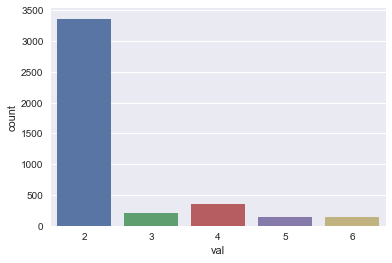

In [173]:
sns.countplot(x='val', data=datasetValida)

In [171]:
datasetValida.head()

,id,txt,cit,data,cit.1,val,int
0,onnabia,"""apenas um filme lésbico pode me alegrar neste...","Rio de Janeiro, Brasil",10/27/17 00:14,6,2,4
1,onnabia,"""fodase só queria alguém que me amasse e aceit...","Rio de Janeiro, Brasil",10/27/17 00:08,6,4,4
2,onnabia,"""já deu pra mim, já tentei de todas as maneira...","Rio de Janeiro, Brasil",10/27/17 00:01,6,2,4
3,onnabia,"""se liga vou fazer um drama""","Rio de Janeiro, Brasil",10/27/17 00:00,6,2,4
4,onnabia,"""me sentindo levemente suicida""","Rio de Janeiro, Brasil",10/26/17 23:57,5,2,4


In [172]:
datasetValida.to_csv('output-classificador-com-demoji.csv', ",", index=False)
print("Arquivo gerado: output-classificador-com-dmoji.csv ")

Arquivo gerado: output-classificador-com-dmoji.csv 


# Drafts

In [ ]:
# train classifier
clf = MultinomialNB(alpha=0.5).fit(train, trainTarget)

# test clf on test data
X_test_rfecv = rfecv.transform(X_test_tfidf)

predicted = clf.predict(X_test_rfecv) 

print("\nAccuracy Training: " + str(np.mean(predicted == labels_test)))

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# train classifier
clf = svm.fit(X_rfecv, labels_train)

# test clf on test data
X_test_rfecv = rfecv.transform(X_test_tfidf)

predicted = clf.predict(X_test_rfecv) 

print("\nAccuracy Training: " + str(np.mean(predicted == labels_test)))

In [ ]:
print("confusion matrix")
# split the data into train and test
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(
    dataset.data, dataset.target, test_size = 0.1, random_state = 10)

fit_classifier(train_data, train_labels)
predicted = predict(test_data)
# 0 = alt.atheism, 1 = comp.graphics, 2 = sci.med, 3 = soc.religion.christian
print(confusion_matrix(test_labels, predicted, labels = [0, 1, 2, 3]))

In [ ]:
## Todos os registros
classifier.fit(sentencesWithoutStopWords, datasetInFrame["val"].values)

In [ ]:
def predict(test_data):
	test_counts = count_vector.transform(test_data)
	test_tfidf = tfidf.transform(test_counts)
return classifier.predict(test_tfidf)

In [ ]:
wordcloud(names(count_vect.vocabulary_), v, min.freq=10, scale=c(10,.3))


In [ ]:
from os import path
from wordcloud import WordCloud

d = path.dirname(__file__)

# Read the whole text.
text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()